# 원, 삼각형, 사각형 구분하기
- 어려운 테스트 문제를 데이터 부풀리기를 이용하여 데이터를 많이 생성
- 기존 CNN 모델 사용

In [1]:
from google.colab import files
up = files.upload()

Saving hard_handwriting_shape.zip to hard_handwriting_shape.zip


In [2]:
!unzip hard_handwriting_shape.zip -d hard_handwriting_shape > /dev/null

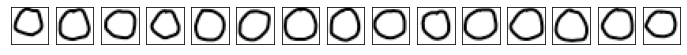

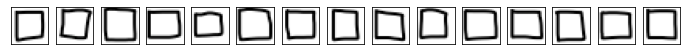

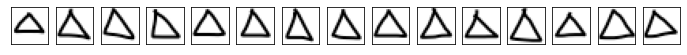

In [3]:
from PIL import Image 
import glob
import matplotlib.pyplot as plt

shapes = ['circle','rectangle','triangle']
for shape in shapes:
    dir_name = f'hard_handwriting_shape/train/{shape}'
    plt.figure(figsize=(12,1))
    for i, fname in enumerate(glob.glob(f'{dir_name}/*.png')):
        img = Image.open(fname)
        plt.subplot(1,15,i+1), plt.imshow(img), plt.xticks([]), plt.yticks([])
    plt.show()

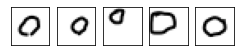

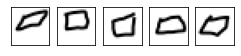

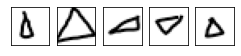

In [4]:
for shape in shapes:
    dir_name = f'hard_handwriting_shape/test/{shape}'
    plt.figure(figsize=(4,1))
    for i, fname in enumerate(glob.glob(f'{dir_name}/*.png')):
        img = Image.open(fname)
        plt.subplot(1,5,i+1), plt.imshow(img), plt.xticks([]), plt.yticks([])
    plt.show()

- 데이터셋 생성하기

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8, 2.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img('hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 24, 24, 3)

- 데이터 부풀리기를 통하여 만들어지는 새로운 도형 이미지

In [7]:
import os
if not os.path.exists('preview'):
    os.mkdir('preview')

In [8]:
count = 0
for _ in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='tri'):
    count += 1
    if count >= 30:
        break

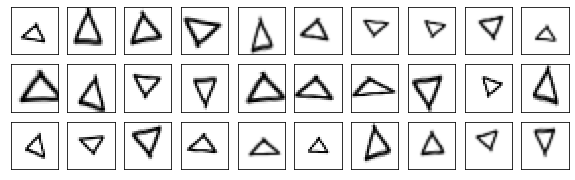

In [9]:
plt.figure(figsize=(10,3))
for i, fname in enumerate(glob.glob('preview/*.png')):
    img = Image.open(fname)
    plt.subplot(3,10,i+1)
    plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
train_data_generator = train_datagen.flow_from_directory(
    'hard_handwriting_shape/train',
    target_size=(24,24),
    batch_size=3,
    class_mode='categorical'
)

Found 45 images belonging to 3 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(
    'hard_handwriting_shape/test',
    target_size=(24,24),
    batch_size=3,
    class_mode='categorical'
)

Found 15 images belonging to 3 classes.


- 모델 정의/설정

In [12]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [14]:
model = Sequential([ 
    Conv2D(32, (3,3), input_shape=(24,24,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [15]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

- 모델 학습

In [16]:
hist = model.fit(
    train_data_generator,   # 훈련데이터셋을 제공할 제네레이터
    steps_per_epoch=15,     
    epochs=300, verbose=0,
    validation_data=test_data_generator,    # 검증데이터셋을 제공할 제네레이터
    validation_steps=5      # 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수
)

- 모델 평가

In [17]:
model.evaluate(test_data_generator, steps=5)

5/5 [==============================] - 0s 5ms/step - loss: 2.7438 - accuracy: 0.7333


[2.7438464164733887, 0.7333333492279053]

- 학습과정 시각화

In [18]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1,len(y_acc)+1)

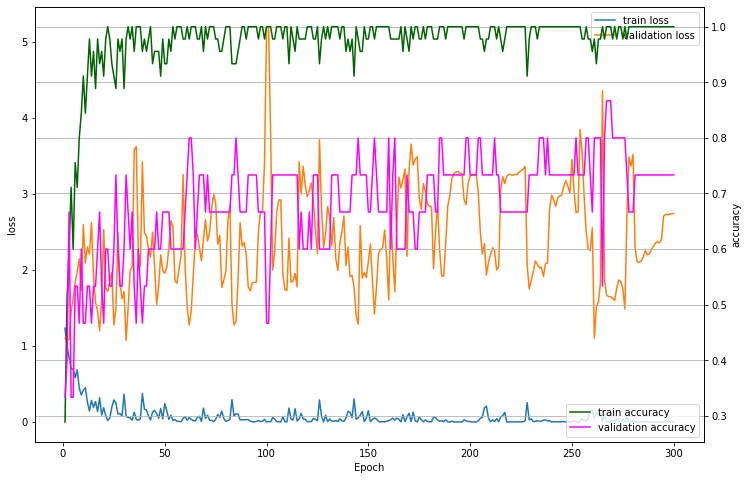

In [20]:
_, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, label='train loss')
ax0.plot(xs, y_vloss, label='validation loss')
ax0.set_ylabel('loss')
ax1.plot(xs, y_acc, c='darkgreen', label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta', label='validation accuracy')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('Epoch')
ax0.legend(), ax1.legend()
plt.grid()
plt.show()